In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers, models

Test and configure GPU

In [3]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)
# else:
#     print('No GPUs detected')

In [4]:
# #tf.debugging.set_log_device_placement(True)
# # Create some tensors
# a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# c = tf.matmul(a, b)
# print(c)

# #tf.debugging.set_log_device_placement(False)

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
meta_path = "cov_data/metadata.csv"
data_path = "cov_data"

In [7]:
metadata = pd.read_csv(meta_path,delimiter=',',names=['fn','class'],skiprows=1)
metadata[:5]

,fn,class
0,covid/COVID19(308).jpg,1
1,covid/COVID-19 (839).jpg,1
2,covid/COVID-19 (105).jpg,1
3,covid/COVID-19 (379).jpg,1
4,covid/COVID19(443).jpg,1


Can discard metadata? Labels are determined by folders (covid/pneum/normal).
Can try merging normal and pneum.

Look into different ways to resize (keras resize tutorial)

In [8]:
def load_data(data_path: str, meta_path: str, norm: bool = True):
    metadata = pd.read_csv(meta_path,delimiter=',',names=['fn','class'],skiprows=1).to_numpy()
    images, classes = [], []
    for fn_cl in metadata:
        fn = fn_cl[0]
        cl = fn_cl[1]
        im = load_image('/'.join([data_path, fn]))
        if im is None:
            continue
        images.append(np.array(im) / 256 if norm else np.array(im))
        classes.append(cl)
    return np.array(images),np.array(classes)

In [9]:
def load_image(filename: str, sizeX: int=256, sizeY: int=256):
    img = cv2.imread(filename)
    if img is None:
        pass
    else:
        img = tf.image.rgb_to_grayscale(np.array(cv2.resize(img, (sizeX, sizeY)), dtype='float32'))
    return img

In [10]:
def load_data_os(data_path: str):
    images_covid = [load_image('/'.join([data_path, 'covid', fn])) for fn in os.listdir('C:/Users/xps/unipd/hda/C4/proj/cov_data/covid')]
    images_pneum = [load_image('/'.join([data_path, 'pneumonia', fn])) for fn in os.listdir('C:/Users/xps/unipd/hda/C4/proj/cov_data/pneumonia')]
    images_norm = [load_image('/'.join([data_path, 'normal', fn])) for fn in os.listdir('C:/Users/xps/unipd/hda/C4/proj/cov_data/normal')]
    images = np.array(images_norm + images_covid + images_pneum)
    classes = list(np.zeros(np.shape(images_norm)[0])) + list(np.ones(np.shape(images_covid)[0])) + list(2 * np.ones(np.shape(images_pneum)[0]))
    return images, np.array(classes)

In [11]:
def load_data_tf(data_path: str, img_shape=(256,256), batch_size: int=64):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="training",
        label_mode='categorical',
        seed=123,
        image_size=img_shape,
        batch_size=batch_size)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="validation",
        label_mode='categorical',
        seed=123,
        image_size=img_shape,
        batch_size=batch_size)
    return train_ds, val_ds

In [12]:
train_ds, val_ds = load_data_tf('cov_data')

Found 4575 files belonging to 3 classes.
Using 3660 files for training.
Found 4575 files belonging to 3 classes.
Using 915 files for validation.


In [13]:

# train_ds_gr = train_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
# val_ds_gr = val_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


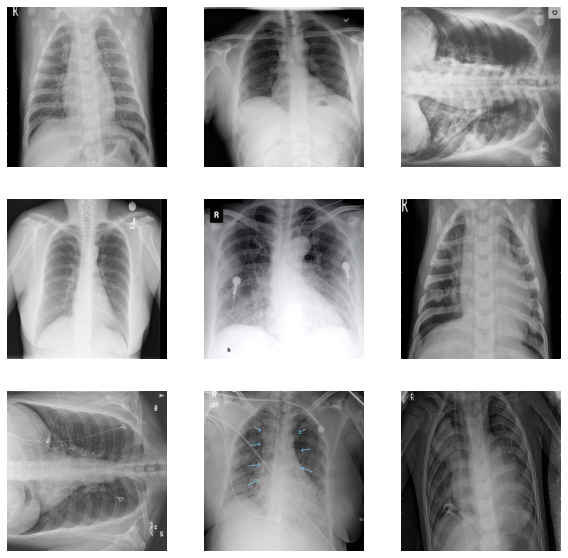

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(train_ds.class_names[labels[i]])
    print(labels[i])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 256, 256, 3)
(64, 3)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

THE ATTENTION MODEL. HANDLE WITH CARE - MAY CAUSE COMPUTER TO EXPLODE VIOLENTLY

In [24]:
from keras import backend as K

# ATTENTION MODEL

''' FIRST CONV BLOCK '''
l_input = layers.Input(shape=(256,256,3))
l_norm = tf.keras.layers.Rescaling(1./255) (l_input)
conv_1_1 = layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='same', name='conv_1_1') (l_norm)
bn_1_1 = layers.BatchNormalization() (conv_1_1)
conv_1_2 = layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='same', name='conv_1_2') (bn_1_1)
bn_1_2 = layers.BatchNormalization() (conv_1_2)
drop_1 = layers.Dropout(rate=0.2, name='drop_1') (bn_1_2)

# this gets passed on to the attention mechanism
l_dense_con_1 = layers.Dense(units=64, activation=None,name='conn_1')(drop_1)

pool_1 = layers.MaxPooling2D(pool_size=(2,2),name='pool_1') (drop_1)

''' SECOND CONV BLOCK '''
conv_2_1 = layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same', name='conv_2_1') (pool_1)
bn_2_1 = layers.BatchNormalization() (conv_2_1)
conv_2_2 = layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same', name='conv_2_2') (bn_2_1)
bn_2_2 = layers.BatchNormalization() (conv_2_2)
drop_2 = layers.Dropout(rate=0.2,name='drop_2') (bn_2_2)

l_dense_con_2 = layers.Dense(units=64, activation=None,name='conn_2')(drop_2)

pool_2 = layers.MaxPooling2D(pool_size=(2,2),name='pool_2') (drop_2)

''' THIRD CONV BLOCK '''
conv_3_1 = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv_3_1') (pool_2)
bn_3_1 = layers.BatchNormalization() (conv_3_1)
conv_3_2 = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv_3_2') (bn_3_1)
bn_3_2 = layers.BatchNormalization() (conv_3_2)
drop_3 = layers.Dropout(rate=0.2,name='drop_3') (bn_3_2)

l_dense_con_3 = layers.Dense(units=64, activation=None,name='conn_3')(drop_3)

pool_3 = layers.MaxPooling2D(pool_size=(2,2),name='pool_3') (drop_3)

''' FINAL CONV BLOCK, GIVES THE FINAL REPRESENTATION (g) '''
conv_4_1 = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv_4_1') (pool_3)
bn_4_1 = layers.BatchNormalization() (conv_4_1)
pool_4_2 = layers.MaxPooling2D(pool_size=(2,2),name='pool_4_2') (bn_4_1)

flat_g = layers.Flatten(name='flat_g') (pool_4_2)
drop_g = layers.Dropout(rate=0.4,name='drop_g') (flat_g)
g = layers.Dense(units=64,activation='relu',name='g') (drop_g)

""" Calculate compatibility scores """
# dot product of l_i's and g
c_1 = layers.Lambda(lambda lam: K.squeeze(K.map_fn(fn=lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype=tf.float32), 3), name='cdp1')([l_dense_con_1, g])
flat_1 = layers.Flatten() (c_1)
act_1 = layers.Softmax() (flat_1)
c_2 = layers.Lambda(lambda lam: K.squeeze(K.map_fn(fn=lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype=tf.float32), 3), name='cdp2')([l_dense_con_2, g])
flat_2 = layers.Flatten() (c_2)
act_2 = layers.Softmax() (flat_2)
c_3 = layers.Lambda(lambda lam: K.squeeze(K.map_fn(fn=lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype=tf.float32), 3), name='cdp3')([l_dense_con_3, g])
flat_3 = layers.Flatten() (c_3)
act_3 = layers.Softmax() (flat_3)

rs_1 = layers.Reshape((-1,64)) (l_dense_con_1)
g_a_1 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), 
             name='ga1')([act_1,rs_1])

rs_2 = layers.Reshape((-1,64)) (l_dense_con_2)
g_a_2 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), 
             name='ga2')([act_2,rs_2])

rs_3 = layers.Reshape((-1,64)) (l_dense_con_3)
g_a_3 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), 
             name='ga3')([act_3,rs_3])

l_concat = layers.Concatenate() ([g_a_1, g_a_2, g_a_3]) # concatenate the three attention outputs
l_dense_out = layers.Dense(units = 3, activation='softmax') (l_concat)

model_att = models.Model(inputs=l_input, outputs=l_dense_out)
model_att.save_weights('model_att_init_weights.h5')

model_att.summary()
tf.keras.utils.plot_model(model_att, 'model_att.png', show_shapes=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv_1_1 (Conv2D)              (None, 256, 256, 16  448         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

In [18]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',input_shape=(256,256,3)))
# model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.Dropout(rate=0.2))
# model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.Dropout(rate=0.2))
# model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.Dropout(rate=0.2))
# model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.Dropout(rate=0.2))
# model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.Dropout(rate=0.2))
# model.add(layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.Dropout(rate=0.2))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(3, activation='softmax'))

In [19]:
# model.summary()

In [20]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
#               metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [25]:
model_att.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [22]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

history = model_att.fit(train_ds, epochs=50,
                    validation_data=val_ds) 

Epoch 1/50
58/58 [==============================] - 446s 8s/step - loss: 0.9924 - categorical_accuracy: 0.4770 - auc: 0.6858 - precision: 0.7181 - recall: 0.1781 - val_loss: 0.6917 - val_categorical_accuracy: 0.7639 - val_auc: 0.8802 - val_precision: 0.8147 - val_recall: 0.7158
Epoch 2/50
58/58 [==============================] - 425s 7s/step - loss: 0.6107 - categorical_accuracy: 0.7478 - auc: 0.8998 - precision: 0.7768 - recall: 0.6943 - val_loss: 0.7621 - val_categorical_accuracy: 0.6699 - val_auc: 0.8403 - val_precision: 0.7200 - val_recall: 0.6098
Epoch 3/50
58/58 [==============================] - 414s 7s/step - loss: 0.6315 - categorical_accuracy: 0.7276 - auc: 0.8918 - precision: 0.7688 - recall: 0.6604 - val_loss: 0.6000 - val_categorical_accuracy: 0.7596 - val_auc: 0.9125 - val_precision: 0.8720 - val_recall: 0.6404
Epoch 4/50
58/58 [==============================] - 421s 7s/step - loss: 0.5157 - categorical_accuracy: 0.8022 - auc: 0.9284 - precision: 0.8177 - recall: 0.7784 -

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components='mle')
# pca.fit(X_train[:,:,:,0])
# X_train_pca = pca.transform(X_train)
# X_test_pca = pca.transform(X_test)
# X_vapca = pca.transform(X_val)

In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

# history = model.fit(X_train, y_train, epochs=15, 
#                     validation_data=(X_val, y_val), callbacks=[callback]) 

Epoch 1/15
86/86 [==============================] - 317s 4s/step - loss: 1.0768 - categorical_accuracy: 0.4015 - auc_1: 0.5879 - precision_1: 0.5532 - recall_1: 0.0379 - val_loss: 1.0211 - val_categorical_accuracy: 0.5683 - val_auc_1: 0.7521 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/15
86/86 [==============================] - 295s 3s/step - loss: 0.9222 - categorical_accuracy: 0.5934 - auc_1: 0.7658 - precision_1: 0.6741 - recall_1: 0.3617 - val_loss: 0.7551 - val_categorical_accuracy: 0.6885 - val_auc_1: 0.8654 - val_precision_1: 0.7844 - val_recall_1: 0.5486
Epoch 3/15
86/86 [==============================] - 309s 4s/step - loss: 0.6911 - categorical_accuracy: 0.7122 - auc_1: 0.8752 - precision_1: 0.7647 - recall_1: 0.6335 - val_loss: 0.7126 - val_categorical_accuracy: 0.7628 - val_auc_1: 0.9027 - val_precision_1: 0.9014 - val_recall_1: 0.4798
Epoch 4/15
86/86 [==============================] - 310s 4s/step - loss: 0.6191 - categorical_accuracy: 0.7501 - auc_1:

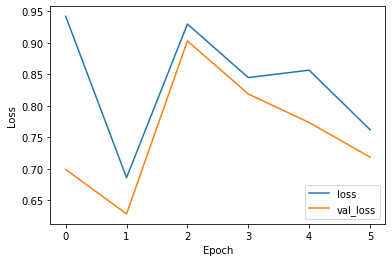

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [ ]:
test_loss, test_acc, test_auc, test_precision, test_recall = model_att.evaluate(val_ds, verbose=2)

NameError: name 'model' is not defined

In [ ]:
preds = np.argmax(model_att.predict(X_test), axis=-1)
m = tf.math.confusion_matrix(labels=np.argmax(y_test,axis=-1), predictions=preds)

In [ ]:
m

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[318,  15,   1],
       [ 24, 251,   2],
       [ 35,   5, 264]])>

In [ ]:
test_acc

0.9103825092315674

LOADING FROM FOLDERS: 800 more images, but may contain mistakes (otherwise why would they skip some images in metadata)